In [1]:
# Author: Yusuf Baran Tanrıverdi 
# Contact: yusufbtanriverdi@hotmail.com

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import itertools
from tqdm import tqdm
from sklearn.gaussian_process.kernels import ConstantKernel, WhiteKernel, RBF, Matern, RationalQuadratic, \
    ExpSineSquared, DotProduct
from sklearn.metrics import r2_score, mean_absolute_error
import pickle
from sklearn.preprocessing import StandardScaler

import warnings
from sklearn.exceptions import ConvergenceWarning
from scipy import signal as s

from sklearn.linear_model import LinearRegression

import time
import joblib

import multiprocess as mp
from functools import partial
import os

import datetime

from sklearn.gaussian_process import GaussianProcessRegressor
import warnings
from sklearn.exceptions import ConvergenceWarning

In [2]:
from statsmodels.tsa.stattools import adfuller


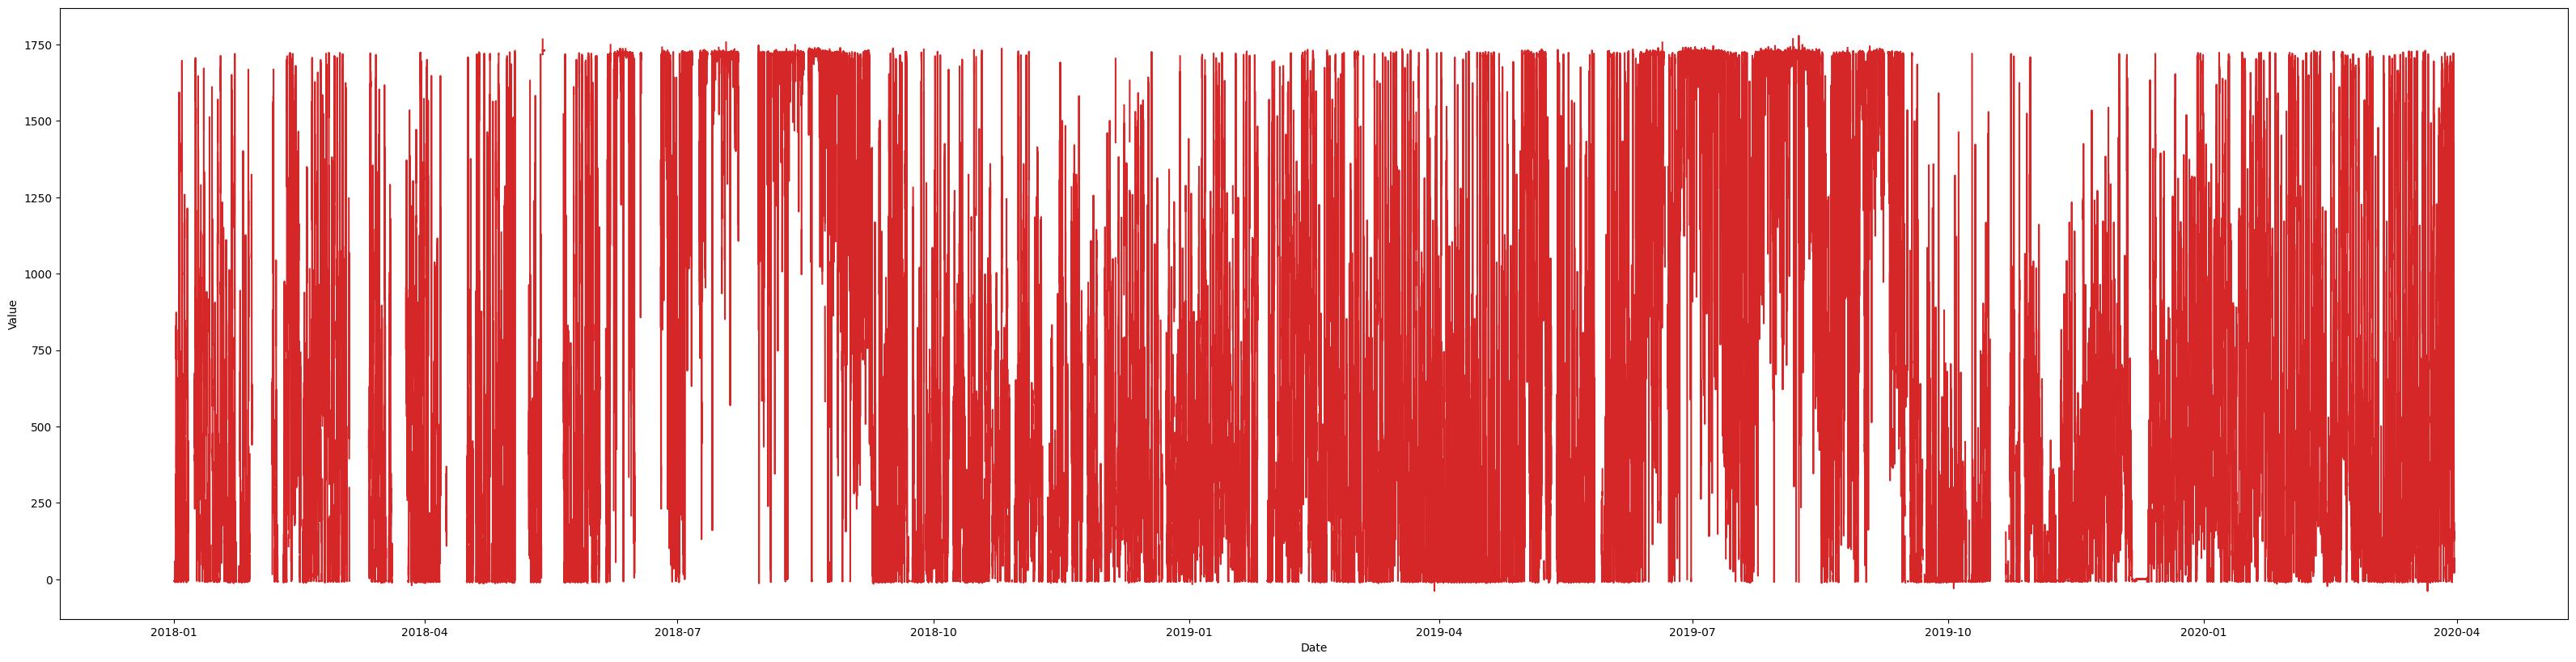

118224

In [3]:
def plot_df(df, x_col, y_col, title='', xlabel='Date', ylabel='Value', dpi=100):
    """ Function to plot time-series data """
    
    x = df[x_col]
    y = df[y_col]
    
    plt.figure(figsize=(40,10), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

# Read data
df = pd.read_csv('Turbine_Data.csv', parse_dates=['Unnamed: 0'])

df.rename({'Unnamed: 0': 'Date'}, axis=1, inplace=True)

# Plot all data   
plot_df(df, x_col='Date', y_col='ActivePower', title='') 

len(df) # Number of samples

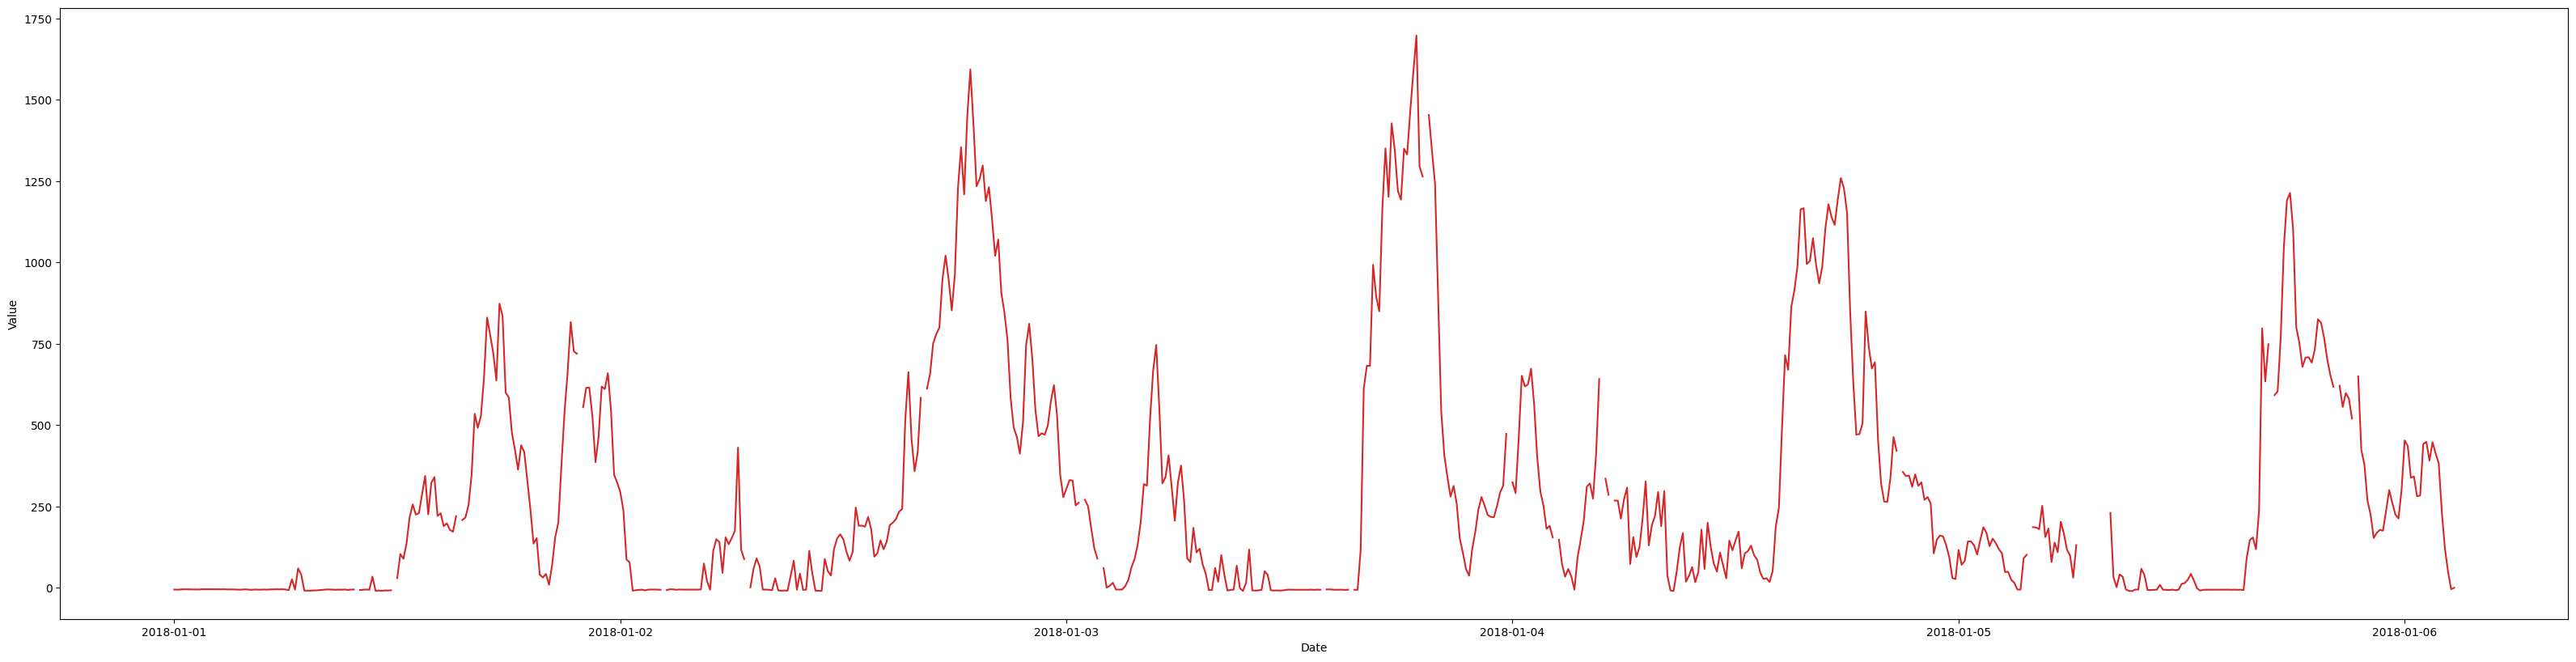

In [4]:
# To make anaylsis faster, compherensible we may limit data to some number

plot_df( df[:1000], x_col='Date', y_col='ActivePower', title='') # Plot all data   

In [5]:
df

,Date,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
0,2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
1,2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2,2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
3,2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
4,2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468


In [6]:
df.columns

Index(['Date', 'ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'ControlBoxTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
       'WindDirection', 'WindSpeed'],
      dtype='object')

In [7]:
df = df[['Date', 
         'ActivePower', 
         'NacellePosition',
         'RotorRPM', 
         'Blade1PitchAngle', 'Blade2PitchAngle','Blade3PitchAngle',
         'WindDirection', 'WindSpeed']]

In [8]:
df = df.dropna(axis=0, subset= ['Date', 
         'ActivePower', 
         'NacellePosition', 
         'RotorRPM', 
         'Blade1PitchAngle', 'Blade2PitchAngle','Blade3PitchAngle',
         'WindDirection', 'WindSpeed'])

In [9]:
df['PitchAngle'] = df[['Blade1PitchAngle','Blade2PitchAngle','Blade3PitchAngle']].mean(axis=1)

In [10]:
df = df[['Date', 
         'ActivePower', 
         'NacellePosition', 
         'RotorRPM', 
         'PitchAngle',
         'WindDirection', 'WindSpeed']]

df

,Date,ActivePower,NacellePosition,RotorRPM,PitchAngle,WindDirection,WindSpeed
70789,2019-05-06 14:10:00+00:00,-7.851491,44.80,0.672715,44.378536,44.80,2.212693
70791,2019-05-06 14:30:00+00:00,-5.565284,49.00,0.508198,41.260252,49.00,2.130019
70793,2019-05-06 14:50:00+00:00,-5.549332,61.50,0.715614,39.576107,61.50,2.347810
70794,2019-05-06 15:00:00+00:00,-5.768376,93.25,0.550434,47.999508,93.25,2.161460
70795,2019-05-06 15:10:00+00:00,-5.091456,138.50,0.251628,50.363662,138.50,1.913490
...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,178.00,9.234004,1.805282,178.00,3.533445
118220,2020-03-30 23:20:00+00:00,40.833474,178.00,9.229370,1.992091,178.00,3.261231
118221,2020-03-30 23:30:00+00:00,20.777790,178.00,9.236802,1.995181,178.00,3.331839
118222,2020-03-30 23:40:00+00:00,62.091039,190.00,9.237374,1.864971,190.00,3.284468


In [11]:
date = df['Date']
date.values

array(['2019-05-06T14:10:00.000000000', '2019-05-06T14:30:00.000000000',
       '2019-05-06T14:50:00.000000000', ...,
       '2020-03-30T23:30:00.000000000', '2020-03-30T23:40:00.000000000',
       '2020-03-30T23:50:00.000000000'], dtype='datetime64[ns]')

In [12]:
date = np.asarray(date.values, dtype='datetime64[s]')
date

array(['2019-05-06T14:10:00', '2019-05-06T14:30:00',
       '2019-05-06T14:50:00', ..., '2020-03-30T23:30:00',
       '2020-03-30T23:40:00', '2020-03-30T23:50:00'],
      dtype='datetime64[s]')

In [13]:
date_float = date.astype("float")
date[0], date_float[0]

(numpy.datetime64('2019-05-06T14:10:00'), 1557151800.0)

In [14]:
# Check correctness
datetime.datetime.utcfromtimestamp(date_float[0])

datetime.datetime(2019, 5, 6, 14, 10)

In [15]:
df['DateF'] = date_float
df

,Date,ActivePower,NacellePosition,RotorRPM,PitchAngle,WindDirection,WindSpeed,DateF
70789,2019-05-06 14:10:00+00:00,-7.851491,44.80,0.672715,44.378536,44.80,2.212693,1.557152e+09
70791,2019-05-06 14:30:00+00:00,-5.565284,49.00,0.508198,41.260252,49.00,2.130019,1.557153e+09
70793,2019-05-06 14:50:00+00:00,-5.549332,61.50,0.715614,39.576107,61.50,2.347810,1.557154e+09
70794,2019-05-06 15:00:00+00:00,-5.768376,93.25,0.550434,47.999508,93.25,2.161460,1.557155e+09
70795,2019-05-06 15:10:00+00:00,-5.091456,138.50,0.251628,50.363662,138.50,1.913490,1.557155e+09
...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,178.00,9.234004,1.805282,178.00,3.533445,1.585610e+09
118220,2020-03-30 23:20:00+00:00,40.833474,178.00,9.229370,1.992091,178.00,3.261231,1.585610e+09
118221,2020-03-30 23:30:00+00:00,20.777790,178.00,9.236802,1.995181,178.00,3.331839,1.585611e+09
118222,2020-03-30 23:40:00+00:00,62.091039,190.00,9.237374,1.864971,190.00,3.284468,1.585612e+09


In [16]:
# Define columns to use.
feature_cols = df.columns[3:-1]
target_col = df.columns[1]

In [17]:
feature_cols

Index(['RotorRPM', 'PitchAngle', 'WindDirection', 'WindSpeed'], dtype='object')

In [18]:
# Split train and validation sets according to 80-20 convenience. 

boundary = int(len(df)*0.8)

df_train = df[:boundary]
df_test  = df[boundary:]

print("Training set size:", len(df_train))
print("Validation set size:", len(df_test))

df.iloc[boundary,:]

Training set size: 26529
Validation set size: 6633


Date               2020-02-09 07:30:00+00:00
ActivePower                        152.32495
NacellePosition                        186.5
RotorRPM                            9.387916
PitchAngle                          1.050224
WindDirection                          186.5
WindSpeed                           4.040589
DateF                           1581233400.0
Name: 110925, dtype: object

In [19]:
# Create X and y data.
X_train = df_train[feature_cols]
X_test = df_test[feature_cols]

y_train = df_train[target_col]
y_test = df_test[target_col]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((26529, 4), (6633, 4), (26529,), (6633,))

In [20]:
# Scale features within their std and means

sc = StandardScaler()

X_train = sc.fit_transform(np.array(X_train)) 
X_test = sc.transform(np.array(X_test))

SECTION 3: RUN AND EVALUATE RESULTS

In [21]:
# Instantiate a Gaussian Process model
kernel = RBF() + ExpSineSquared()
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

In [22]:
# Fit to data using Maximum Likelihood Estimation of the parameters.
gp.fit(X_train[24518:-1], y_train[24518:-1])

C:\Users\baran.tanriverdi\Anaconda3\envs\tf\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1) + ExpSineSquared(length_scale=1, periodicity=1),
                         n_restarts_optimizer=9)

In [23]:
gp.score(X_train[24518:-1], y_train[24518:-1])

1.0

In [24]:
gp.score(X_test[:1500], y_test[:1500])

0.9571600004233207

In [25]:
np.asarray(y_test)

array([152.32494987, 179.2672532 ,  65.24283831, ...,  20.77778972,
        62.09103858,  68.66442478])

In [26]:
y_test_pred = gp.predict(X_test[:1500])
y_train_pred = gp.predict(X_train[24518:-1])

In [27]:
y_train_pred, y_train[24518:-1], X_train[24518:-1]

(array([1113.92387421,  990.2471165 ,  814.03787526, ...,  223.14967727,
           9.90449177,   14.50213642]),
 108388    1113.923874
 108389     990.247116
 108390     814.037875
 108391     907.218265
 108392     895.895348
              ...     
 110919     214.945045
 110920      81.477817
 110921     223.149677
 110922       9.904492
 110923      14.502136
 Name: ActivePower, Length: 2010, dtype: float64,
 array([[ 0.79122641, -0.53533555, -0.42092856,  0.55080801],
        [ 0.6757066 , -0.53350269, -0.30484825,  0.49030292],
        [ 0.49720584, -0.53703103, -0.30484825,  0.41595573],
        ...,
        [-0.0594014 , -0.47990269, -0.08719768, -0.5991428 ],
        [-1.27775773,  0.6449031 , -0.12606385, -1.0453986 ],
        [-1.24891943,  0.53929733, -0.35321504, -0.82059126]]))

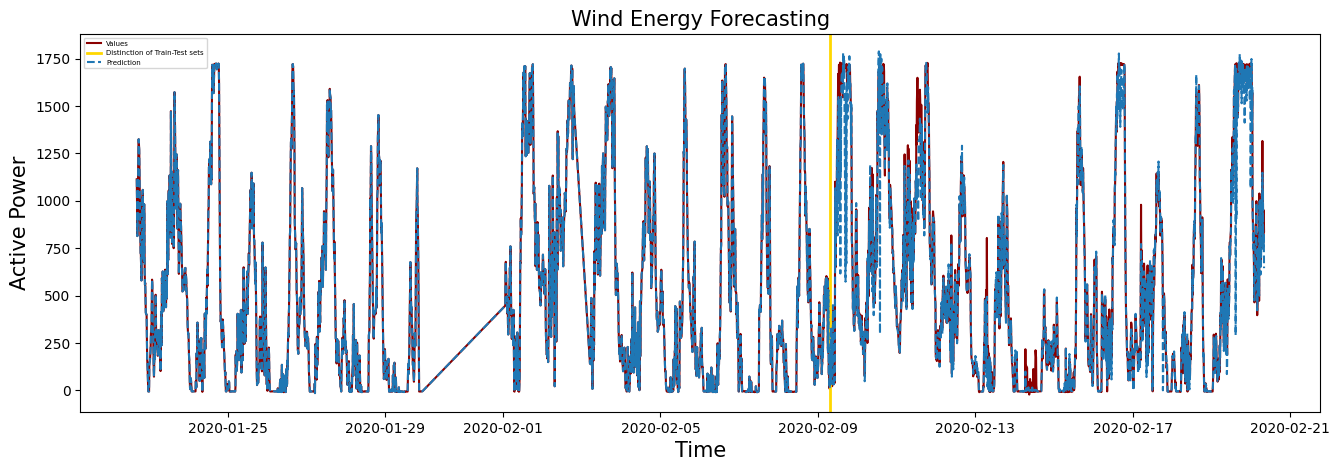

In [30]:
# Copy the main data.
tmp = df

# Convert pandas date format.
tmp["Date"] =  pd.to_datetime(tmp["Date"], format='%Y%m', errors='coerce')

plt.figure(figsize=(16,5), dpi=100)
# Concatenate the ground truth values.
y = np.concatenate([y_train[24518:-1], y_test[:1500]], axis=0)
plt.plot(tmp['Date'][24518:(len(y_train)+1499)], y, color="darkred", label=r"Values")
# Put a line to disctint forecasted timeline.
plt.axvline(x=tmp.iloc[len(y_train)-1].Date, linewidth=2, color='gold', label='Distinction of Train-Test sets')

# Concatenate the predicted values.
y_hat = np.concatenate([y_train_pred, y_test_pred], axis=0)

# You can use plot as well.
plt.plot(tmp['Date'][24518:(len(y_train)+1499)], y_hat, linestyle="--", label="Prediction")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Active Power', fontsize=15)
plt.title('Wind Energy Forecasting', fontsize=15)  
plt.legend(fontsize=5)
plt.show()

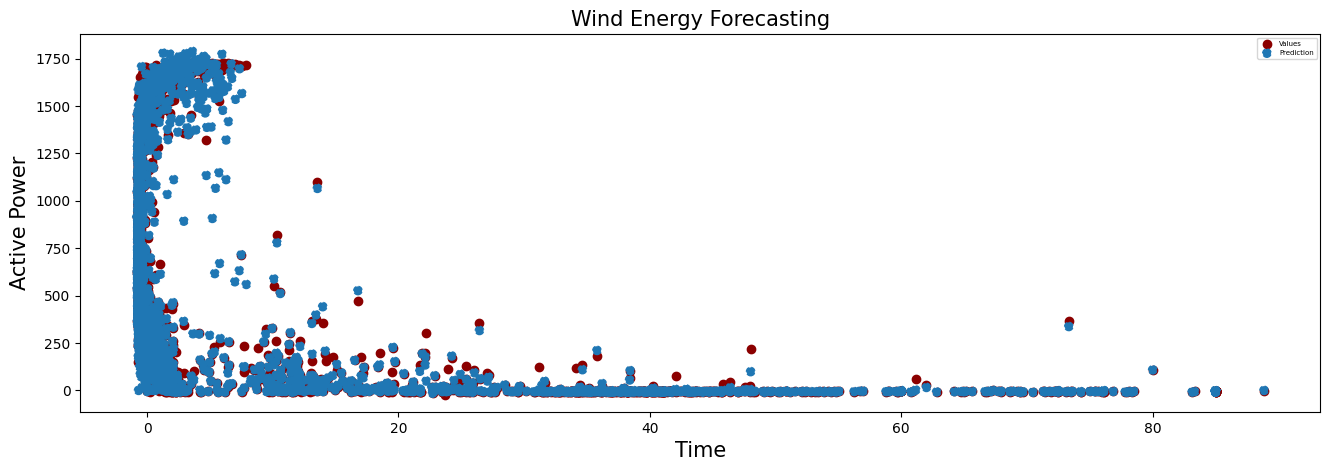

In [31]:
# Copy the main data.
tmp = df

# Convert pandas date format.
tmp["Date"] =  pd.to_datetime(tmp["Date"], format='%Y%m', errors='coerce')

plt.figure(figsize=(16,5), dpi=100)
# Concatenate the ground truth values.
y = np.concatenate([y_train[24518:-1], y_test[:1500]], axis=0)
plt.scatter(tmp['PitchAngle'][24518:(len(y_train)+1499)], y, color="darkred", label=r"Values")
# Put a line to disctint forecasted timeline.
#plt.axvline(x=tmp.iloc[len(y_train)-1].Date, linewidth=2, color='gold', label='Distinction of Train-Test sets')

# Concatenate the predicted values.
y_hat = np.concatenate([y_train_pred, y_test_pred], axis=0)

# You can use plot as well.
plt.scatter(tmp['PitchAngle'][24518:(len(y_train)+1499)], y_hat, linestyle="--", label="Prediction")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Active Power', fontsize=15)
plt.title('Wind Energy Forecasting', fontsize=15)  
plt.legend(fontsize=5)
plt.show()

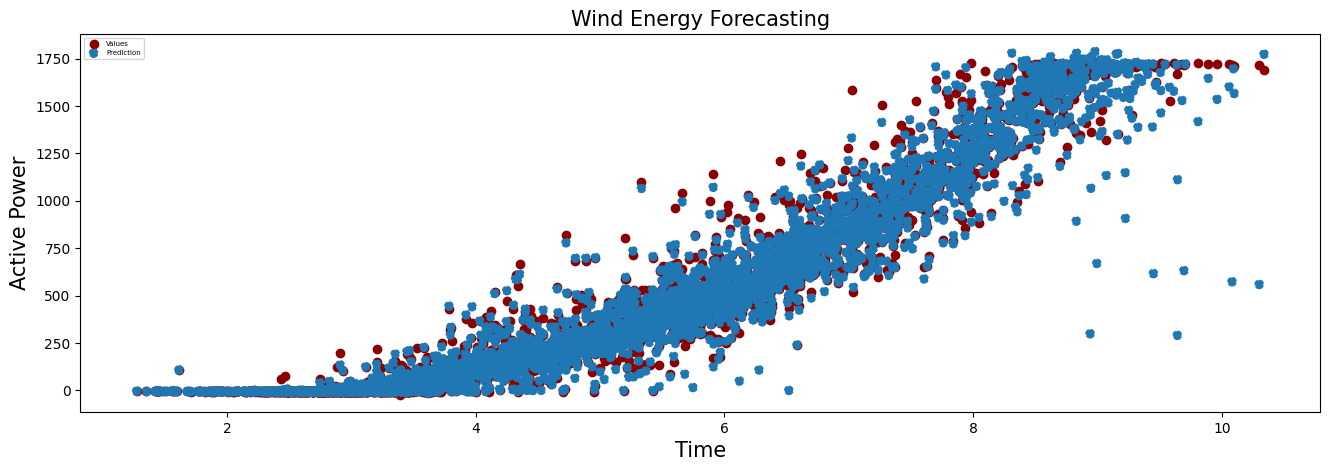

In [32]:
# Copy the main data.
tmp = df

# Convert pandas date format.
tmp["Date"] =  pd.to_datetime(tmp["Date"], format='%Y%m', errors='coerce')

plt.figure(figsize=(16,5), dpi=100)
# Concatenate the ground truth values.
y = np.concatenate([y_train[24518:-1], y_test[:1500]], axis=0)
plt.scatter(tmp['WindSpeed'][24518:(len(y_train)+1499)], y, color="darkred", label=r"Values")
# Put a line to disctint forecasted timeline.
#plt.axvline(x=tmp.iloc[len(y_train)-1].Date, linewidth=2, color='gold', label='Distinction of Train-Test sets')

# Concatenate the predicted values.
y_hat = np.concatenate([y_train_pred, y_test_pred], axis=0)

# You can use plot as well.
plt.scatter(tmp['WindSpeed'][24518:(len(y_train)+1499)], y_hat, linestyle="--", label="Prediction")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Active Power', fontsize=15)
plt.title('Wind Energy Forecasting', fontsize=15)  
plt.legend(fontsize=5)
plt.show()

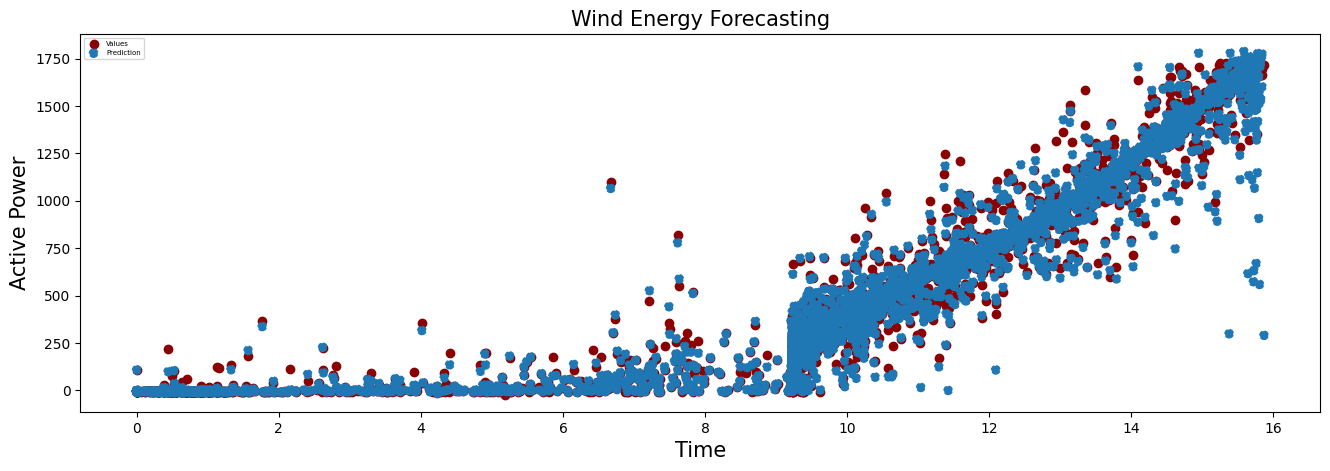

In [33]:
# Copy the main data.
tmp = df

# Convert pandas date format.
tmp["Date"] =  pd.to_datetime(tmp["Date"], format='%Y%m', errors='coerce')

plt.figure(figsize=(16,5), dpi=100)
# Concatenate the ground truth values.
y = np.concatenate([y_train[24518:-1], y_test[:1500]], axis=0)
plt.scatter(tmp['RotorRPM'][24518:(len(y_train)+1499)], y, color="darkred", label=r"Values")
# Put a line to disctint forecasted timeline.
#plt.axvline(x=tmp.iloc[len(y_train)-1].Date, linewidth=2, color='gold', label='Distinction of Train-Test sets')

# Concatenate the predicted values.
y_hat = np.concatenate([y_train_pred, y_test_pred], axis=0)

# You can use plot as well.
plt.scatter(tmp['RotorRPM'][24518:(len(y_train)+1499)], y_hat, linestyle="--", label="Prediction")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Active Power', fontsize=15)
plt.title('Wind Energy Forecasting', fontsize=15)  
plt.legend(fontsize=5)
plt.show()

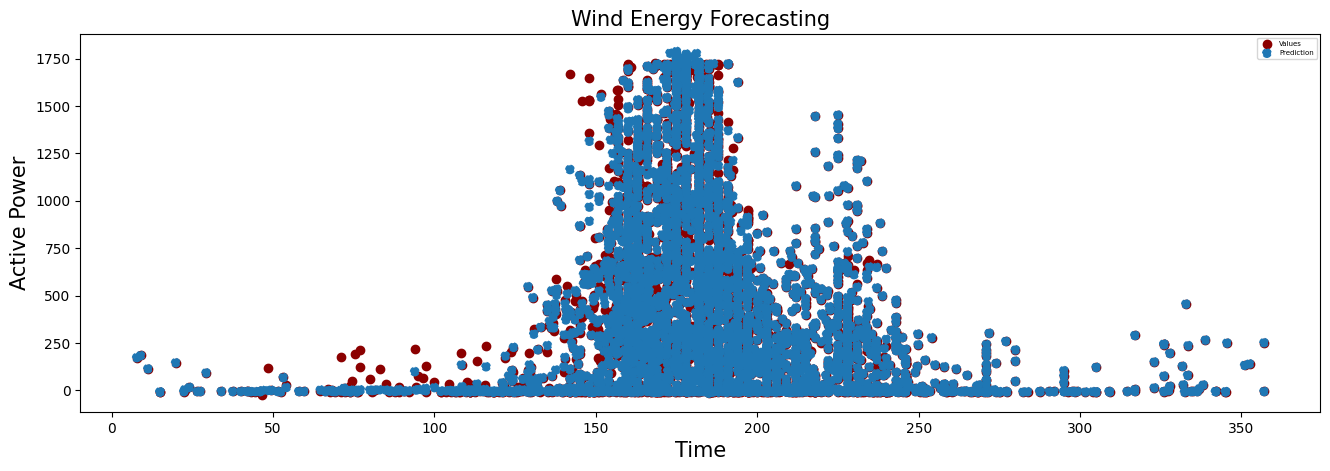

In [34]:
# Copy the main data.
tmp = df

# Convert pandas date format.
tmp["Date"] =  pd.to_datetime(tmp["Date"], format='%Y%m', errors='coerce')

plt.figure(figsize=(16,5), dpi=100)
# Concatenate the ground truth values.
y = np.concatenate([y_train[24518:-1], y_test[:1500]], axis=0)
plt.scatter(tmp['WindDirection'][24518:(len(y_train)+1499)], y, color="darkred", label=r"Values")
# Put a line to disctint forecasted timeline.
#plt.axvline(x=tmp.iloc[len(y_train)-1].Date, linewidth=2, color='gold', label='Distinction of Train-Test sets')

# Concatenate the predicted values.
y_hat = np.concatenate([y_train_pred, y_test_pred], axis=0)

# You can use plot as well.
plt.scatter(tmp['WindDirection'][24518:(len(y_train)+1499)], y_hat, linestyle="--", label="Prediction")

plt.xlabel('Time', fontsize=15)
plt.ylabel('Active Power', fontsize=15)
plt.title('Wind Energy Forecasting', fontsize=15)  
plt.legend(fontsize=5)
plt.show()

In [35]:
joblib.dump(gp, "Gaussian_model")

['Gaussian_model']

In [36]:
# NacellePosition	GeneratorRPM	RotorRPM	PitchAngle	WindDirection	WindSpeed	DateF

date = datetime.datetime.now()

In [37]:
currentDateF = np.datetime64(date).astype("float")

In [38]:
currentWindDirection = df['WindDirection'].mean(axis=0)
currentPitchAngle = df['PitchAngle'].mean(axis=0)
currentRotorRPM = df['RotorRPM'].mean(axis=0)
currentWindSpeed = df['WindSpeed'].mean(axis=0)

features = {}

In [46]:
features["RotorRPM"] = currentRotorRPM
features["PitchAngle"] = currentPitchAngle
features["WindDirection"] = currentWindDirection
features["WindSpeed"] = currentWindSpeed


features

{'RotorRPM': 3, 'PitchAngle': 56, 'WindDirection': 45, 'WindSpeed': 6}

In [47]:
features_tmp = features
feature_vector = np.asarray(list(features_tmp.values())).reshape(1,-1)

In [48]:
test_features = sc.transform(feature_vector)
test_features

array([[-1.38138742,  2.00045273, -1.72475912,  0.00381846]])

In [49]:
gp.predict(test_features)

array([-2.29540915e-10])

In [50]:
best_angle = currentPitchAngle
max_power_val = 0.0
for angle in range(0, 270):
    features_tmp['PitchAngle'] = angle
    feature_vector = np.asarray(list(features_tmp.values())).reshape(1,-1)
    test_features = sc.transform(feature_vector)
    power_val = gp.predict(test_features)
    if max_power_val <= power_val:
        max_power_val = power_val
        best_angle = angle
        print(best_angle, max_power_val)
    else:
        pass
        # print(angle)
# change angle

currentPitchAngle = best_angle

0 [1.71532116e-07]
1 [3.74056677e-07]
2 [7.66921582e-07]
3 [1.47833599e-06]
4 [2.67913579e-06]
5 [4.56466027e-06]
6 [7.31152472e-06]
7 [1.10099827e-05]
8 [1.5586079e-05]
9 [2.07419197e-05]
10 [2.59483597e-05]
11 [3.05142011e-05]
12 [3.37287785e-05]
13 [3.50405878e-05]


In [51]:
newData = [np.datetime64(datetime.datetime.now()), 1000, 23, 56, 22, 23, 6, 
           np.datetime64(datetime.datetime.now()).astype("float")
]

In [52]:
local_df = pd.DataFrame(columns=['Date', 
         'ActivePower', 
         'NacellePosition', 
         'GeneratorRPM', 'RotorRPM', 
         'PitchAngle',
         'WindDirection', 'WindSpeed', 'DateF'])

In [53]:
local_df

,Date,ActivePower,NacellePosition,GeneratorRPM,RotorRPM,PitchAngle,WindDirection,WindSpeed,DateF


In [54]:
local_df.append(pd.DataFrame(np.asarray(newData).reshape(1,-1), columns=list(local_df)), ignore_index=True)

ValueError: Shape of passed values is (1, 8), indices imply (1, 9)

In [55]:
newData = [np.datetime64(datetime.datetime.now()),
           1000, 45,
           currentRotorRPM,
           currentWindDirection, currentWindSpeed,
           np.datetime64(datetime.datetime.now()).astype("float")]

In [58]:
import csv

outfile = open("data.csv", "w")
writer=csv.writer(outfile)
writer.writerow(['Date', 'ActivePower', 'NacellePosition', 'GeneratorRPM',
                 'RotorRPM',
                 'PitchAngle'
                 'WindDirection'
                 'WindSpeed'
                 'DateF'])
writer.writerow(newData)

109

In [59]:
pd.read_csv("data.csv")

,Date,ActivePower,NacellePosition,GeneratorRPM,RotorRPM,PitchAngleWindDirectionWindSpeedDateF
2022-06-09T20:47:40.414993,1000,45,9.676438,204.689813,5.869186,1.654808e+15


In [60]:
tmp_df = df.copy()
tmp_df = tmp_df[tmp_df.index >= len(local_df)]

In [61]:
tmp_df

,Date,ActivePower,NacellePosition,RotorRPM,PitchAngle,WindDirection,WindSpeed,DateF
70789,2019-05-06 14:10:00+00:00,-7.851491,44.80,0.672715,44.378536,44.80,2.212693,1.557152e+09
70791,2019-05-06 14:30:00+00:00,-5.565284,49.00,0.508198,41.260252,49.00,2.130019,1.557153e+09
70793,2019-05-06 14:50:00+00:00,-5.549332,61.50,0.715614,39.576107,61.50,2.347810,1.557154e+09
70794,2019-05-06 15:00:00+00:00,-5.768376,93.25,0.550434,47.999508,93.25,2.161460,1.557155e+09
70795,2019-05-06 15:10:00+00:00,-5.091456,138.50,0.251628,50.363662,138.50,1.913490,1.557155e+09
...,...,...,...,...,...,...,...,...
118219,2020-03-30 23:10:00+00:00,70.044465,178.00,9.234004,1.805282,178.00,3.533445,1.585610e+09
118220,2020-03-30 23:20:00+00:00,40.833474,178.00,9.229370,1.992091,178.00,3.261231,1.585610e+09
118221,2020-03-30 23:30:00+00:00,20.777790,178.00,9.236802,1.995181,178.00,3.331839,1.585611e+09
118222,2020-03-30 23:40:00+00:00,62.091039,190.00,9.237374,1.864971,190.00,3.284468,1.585612e+09
